<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/b%C3%A0i_gi%E1%BA%A3ng_5___c%C3%A1c_thu%E1%BA%ADt_to%C3%A1n_Federated_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hoàn thành phần bài tập của dự án

Hãy tải lên file CSV của bạn (ví dụ: Assignment_MLBasicsData.csv)!


Saving Assignment_MLBasicsData.csv to Assignment_MLBasicsData (3).csv
Số lượng trạm: 207
Số lượng điểm dữ liệu: 19768


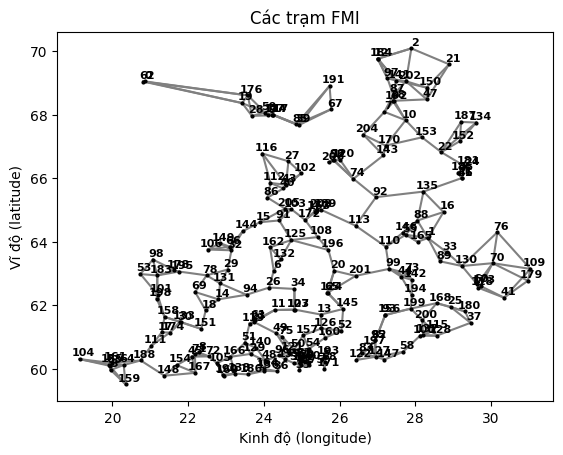


========== Chạy FedGD ==========
Lỗi trung bình trên tập huấn luyện (FedGD): 127.94566654490448
Lỗi trung bình trên tập kiểm tra (FedGD): 126.72576097088802

========== Chạy FedSGD ==========
Lỗi trung bình trên tập huấn luyện (FedSGD): 128.16336667802685
Lỗi trung bình trên tập kiểm tra (FedSGD): 126.9416907060118


In [ ]:
# ===================== PHẦN 1: Chuẩn Bị (Preparation) =====================

# 1.1 Import các thư viện cần thiết
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Thư viện networkx và hàm xây dựng đồ thị k-nearest để lưu trữ và xử lý đồ thị thực nghiệm
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

# ===================== PHẦN 2: ĐỌC DỮ LIỆU =====================

# Với Google Colab, ta sử dụng thư viện files để upload file CSV từ máy tính của bạn.
from google.colab import files
print("Hãy tải lên file CSV của bạn (ví dụ: Assignment_MLBasicsData.csv)!")
uploaded = files.upload()

# Đọc dữ liệu từ file CSV đã tải lên (chỉ cần đổi tên file nếu khác)
data = pd.read_csv(list(uploaded.keys())[0])

# Xác định số lượng trạm (mỗi tên trạm là một giá trị duy nhất) và số lượng điểm dữ liệu.
num_stations = len(data.name.unique())
num_datapoints = len(data)
print("Số lượng trạm:", num_stations)
print("Số lượng điểm dữ liệu:", num_datapoints)

# ===================== PHẦN 3: ĐỊNH NGHĨA HÀM TRỢ GIÚP =====================

# Hàm vẽ đồ thị các trạm FMI theo tọa độ
def plotFMI(G_FMI):
    # Trích xuất tọa độ của từng nút (trạm)
    coords = [G_FMI.nodes[i]['coord'] for i in range(len(G_FMI.nodes))]
    df_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),
                        df_coords["longitude"].to_numpy().reshape(-1,1)))

    # Tạo biểu đồ
    fig, ax = plt.subplots()
    # Vẽ từng nút (trạm)
    for node in G_FMI.nodes:
        ax.scatter(coords[node, 1], coords[node, 0], color='black', s=4, zorder=5)
    # Thêm nhãn cho các nút (số thứ tự)
    for node in G_FMI.nodes:
        ax.text(coords[node,1] + 0.1, coords[node,0] + 0.2, str(node),
                fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Vẽ các cạnh nối các nút với nhau
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1], coords[edge[1],1]],
                [coords[edge[0],0], coords[edge[1],0]],
                linestyle='-', color='gray')

    ax.set_xlabel('Kinh độ (longitude)')
    ax.set_ylabel('Vĩ độ (latitude)')
    ax.set_title('Các trạm FMI')
    plt.show()

# Hàm thêm cạnh (edge) giữa các trạm dựa trên số láng giềng gần nhất
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(len(graph.nodes))]
    df_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),
                        df_coords["longitude"].to_numpy().reshape(-1,1)))
    # Sử dụng hàm kneighbors_graph để tạo ma trận k-láng giềng (k-nearest neighbors)
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for i in range(nrnodes):
        for j in range(nrnodes):
            if i != j and A[i, j] > 0:
                graph.add_edge(i, j)
    return graph

# Hàm trích xuất ma trận đặc trưng (X) và vector nhãn (y) từ dữ liệu của mỗi trạm.
# Mỗi dòng dữ liệu được kỳ vọng có các cột: "Latitude", "Longitude", "temp", "Timestamp".
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    for ind in range(nrdatapoints):
        # Lấy vĩ độ và kinh độ (chuẩn hoá bằng cách chia cho 100)
        lat = float(data['Latitude'].iloc[ind]) / 100
        lon = float(data['Longitude'].iloc[ind]) / 100
        # Lấy giá trị nhiệt độ
        tmp = data['temp'].iloc[ind]
        # Lấy thời gian ghi nhận và chuyển thành đối tượng datetime
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Trích xuất năm, tháng, ngày, giờ, phút và chuẩn hoá về khoảng [0,1]
        year = float(date_object.year) / 2025
        month = float(date_object.month) / 13
        day = float(date_object.day) / 32
        hour = float(date_object.hour) / 25
        minute = float(date_object.minute) / 61
        # Gán giá trị vào ma trận đặc trưng và vector nhãn
        X[ind, :] = [lat, lon, year, month, day, hour, minute]
        y[ind, :] = tmp
    return X, y

# ===================== PHẦN 4: XÂY DỰNG ĐỒ THỊ THỰC NGHIỆM =====================

# Đặt các tham số cho việc chia tập dữ liệu: test_size (tỷ lệ tập kiểm tra) và seed (hạt giống cho random split)
test_size = 0.2
seed = 1

# Tạo đồ thị networkX để lưu trữ các trạm FMI
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(num_stations))

# Với mỗi trạm, trích xuất dữ liệu, tách thành tập huấn luyện và kiểm tra, gán các thuộc tính vào nút
for i, station in enumerate(data.name.unique()):
    station_data = data[data.name == station]
    # Trích xuất ma trận đặc trưng X và vector nhãn y
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

    G_FMI.nodes[i]['samplesize'] = len(y)                               # Số lượng mẫu của trạm
    G_FMI.nodes[i]['name'] = station                                     # Tên trạm
    # Tọa độ của trạm: sử dụng giá trị duy nhất của vĩ độ, kinh độ
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0])
    G_FMI.nodes[i]['X_train'] = X_train                                   # Ma trận đặc trưng huấn luyện
    G_FMI.nodes[i]['y_train'] = y_train                                   # Vector nhãn huấn luyện
    G_FMI.nodes[i]['X_val'] = X_val                                       # Ma trận đặc trưng kiểm tra
    G_FMI.nodes[i]['y_val'] = y_val                                       # Vector nhãn kiểm tra
    # Khởi tạo trọng số (weights) cho mô hình tuyến tính với 7 đặc trưng (ban đầu là vector 0)
    G_FMI.nodes[i]['weights'] = np.zeros((7, 1))

# Thêm các cạnh giữa các nút theo số láng giềng gần nhất.
numneighbors = 3
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)

# Hiển thị đồ thị các trạm FMI.
plotFMI(G_FMI)

# ===================== PHẦN 5: MÔ HÌNH (MODEL) =====================

# Ta thực hiện hai bài tập:
# - FedGD: Federated Gradient Descent (Sử dụng toàn bộ tập huấn luyện cho mỗi trạm)
# - FedSGD: Federated Stochastic Gradient Descent (Sử dụng mini-batch từ tập huấn luyện)

# ---------------- 5.1 FEDGD: Federated Gradient Descent ----------------

print("\n========== Chạy FedGD ==========")
# Đặt siêu tham số cho FedGD
max_iter = 1000     # Số vòng lặp tối đa
alpha = 0.5         # Hệ số chia sẻ trọng số giữa các trạm
l_rate = 0.1        # Learning rate

for iteration in range(max_iter):
    # Khởi tạo biến để tính trọng số chung (global_weights)
    global_weights = np.zeros((7, 1))
    for i in range(num_stations):
        # Lấy trọng số hiện tại và dữ liệu huấn luyện của trạm i
        weights = G_FMI.nodes[i]['weights']
        X_train = G_FMI.nodes[i]['X_train']
        y_train = G_FMI.nodes[i]['y_train']
        # Tính gradient: gradient = (X^T * (X*w - y)) / số mẫu
        gradient = X_train.T @ (X_train @ weights - y_train) / len(y_train)
        # Cập nhật trọng số cho trạm i bằng cách trừ đi learning rate nhân với gradient
        weights = weights - l_rate * gradient
        # Lưu trọng số đã cập nhật vào nút i
        G_FMI.nodes[i]['weights'] = weights
        # Tích lũy trọng số của từng trạm (có thể nhân với hệ số alpha)
        global_weights += alpha * weights
    # Tính trung bình trọng số chung
    global_weights = global_weights / num_stations
    # Đồng bộ hóa trọng số cho tất cả các trạm với trọng số chung
    for i in range(num_stations):
        G_FMI.nodes[i]['weights'] = global_weights

# Tính lỗi huấn luyện và kiểm tra sau khi chạy FedGD
train_errors = np.zeros(num_stations)
val_errors = np.zeros(num_stations)
for i in range(num_stations):
    X_train = G_FMI.nodes[i]['X_train']
    y_train = G_FMI.nodes[i]['y_train']
    X_val = G_FMI.nodes[i]['X_val']
    y_val = G_FMI.nodes[i]['y_val']
    weights = G_FMI.nodes[i]['weights']
    # Dự đoán trên tập huấn luyện và tính lỗi MSE
    train_pred = X_train @ weights
    val_pred = X_val @ weights
    train_errors[i] = mean_squared_error(y_train, train_pred)
    val_errors[i] = mean_squared_error(y_val, val_pred)

print("Lỗi trung bình trên tập huấn luyện (FedGD):", np.mean(train_errors))
print("Lỗi trung bình trên tập kiểm tra (FedGD):", np.mean(val_errors))

# ---------------- 5.2 FEDSGD: Federated Stochastic Gradient Descent ----------------

print("\n========== Chạy FedSGD ==========")
# Thiết lập các siêu tham số cho FedSGD
batch_size = 10
# Reset trọng số cho mỗi trạm về vector 0
for i in range(num_stations):
    G_FMI.nodes[i]['weights'] = np.zeros((7, 1))

for iteration in range(max_iter):
    global_weights = np.zeros((7, 1))
    for i in range(num_stations):
        weights = G_FMI.nodes[i]['weights']
        X_train = G_FMI.nodes[i]['X_train']
        y_train = G_FMI.nodes[i]['y_train']
        # Lấy ngẫu nhiên một batch dữ liệu từ tập huấn luyện của trạm i
        if len(X_train) < batch_size:
            idx = np.arange(len(X_train))
        else:
            idx = np.random.randint(0, len(X_train), size=batch_size)
        X_batch = X_train[idx]
        y_batch = y_train[idx]
        # Tính gradient trên batch: gradient = (X_batch^T * (X_batch*w - y_batch)) / batch_size
        gradient = X_batch.T @ (X_batch @ weights - y_batch) / len(idx)
        weights = weights - l_rate * gradient
        G_FMI.nodes[i]['weights'] = weights
        global_weights += alpha * weights
    global_weights = global_weights / num_stations
    for i in range(num_stations):
        G_FMI.nodes[i]['weights'] = global_weights

# Tính lỗi huấn luyện và kiểm tra sau khi chạy FedSGD
train_errors = np.zeros(num_stations)
val_errors = np.zeros(num_stations)
for i in range(num_stations):
    X_train = G_FMI.nodes[i]['X_train']
    y_train = G_FMI.nodes[i]['y_train']
    X_val = G_FMI.nodes[i]['X_val']
    y_val = G_FMI.nodes[i]['y_val']
    weights = G_FMI.nodes[i]['weights']
    train_pred = X_train @ weights
    val_pred = X_val @ weights
    train_errors[i] = mean_squared_error(y_train, train_pred)
    val_errors[i] = mean_squared_error(y_val, val_pred)

print("Lỗi trung bình trên tập huấn luyện (FedSGD):", np.mean(train_errors))
print("Lỗi trung bình trên tập kiểm tra (FedSGD):", np.mean(val_errors))


Phân tích ảnh hưởng của các hệ số đối với phương pháp học

Hãy tải lên file CSV của bạn (ví dụ: Assignment_MLBasicsData.csv)!


Saving Assignment_MLBasicsData.csv to Assignment_MLBasicsData (5).csv
Số lượng trạm: 207
Số lượng điểm dữ liệu: 19768


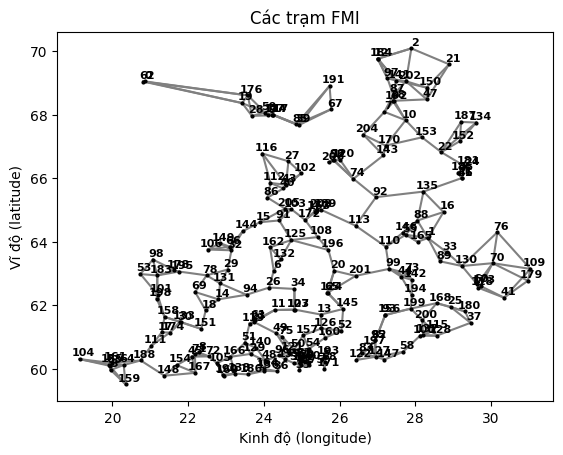


========== Chạy FedGD ==========
Lỗi trung bình tập huấn luyện (FedGD): 127.94566654490448
Lỗi trung bình tập kiểm tra (FedGD): 126.72576097088802

========== Chạy FedSGD ==========
Lỗi trung bình tập huấn luyện (FedSGD): 128.3414281665097
Lỗi trung bình tập kiểm tra (FedSGD): 127.11998379080161


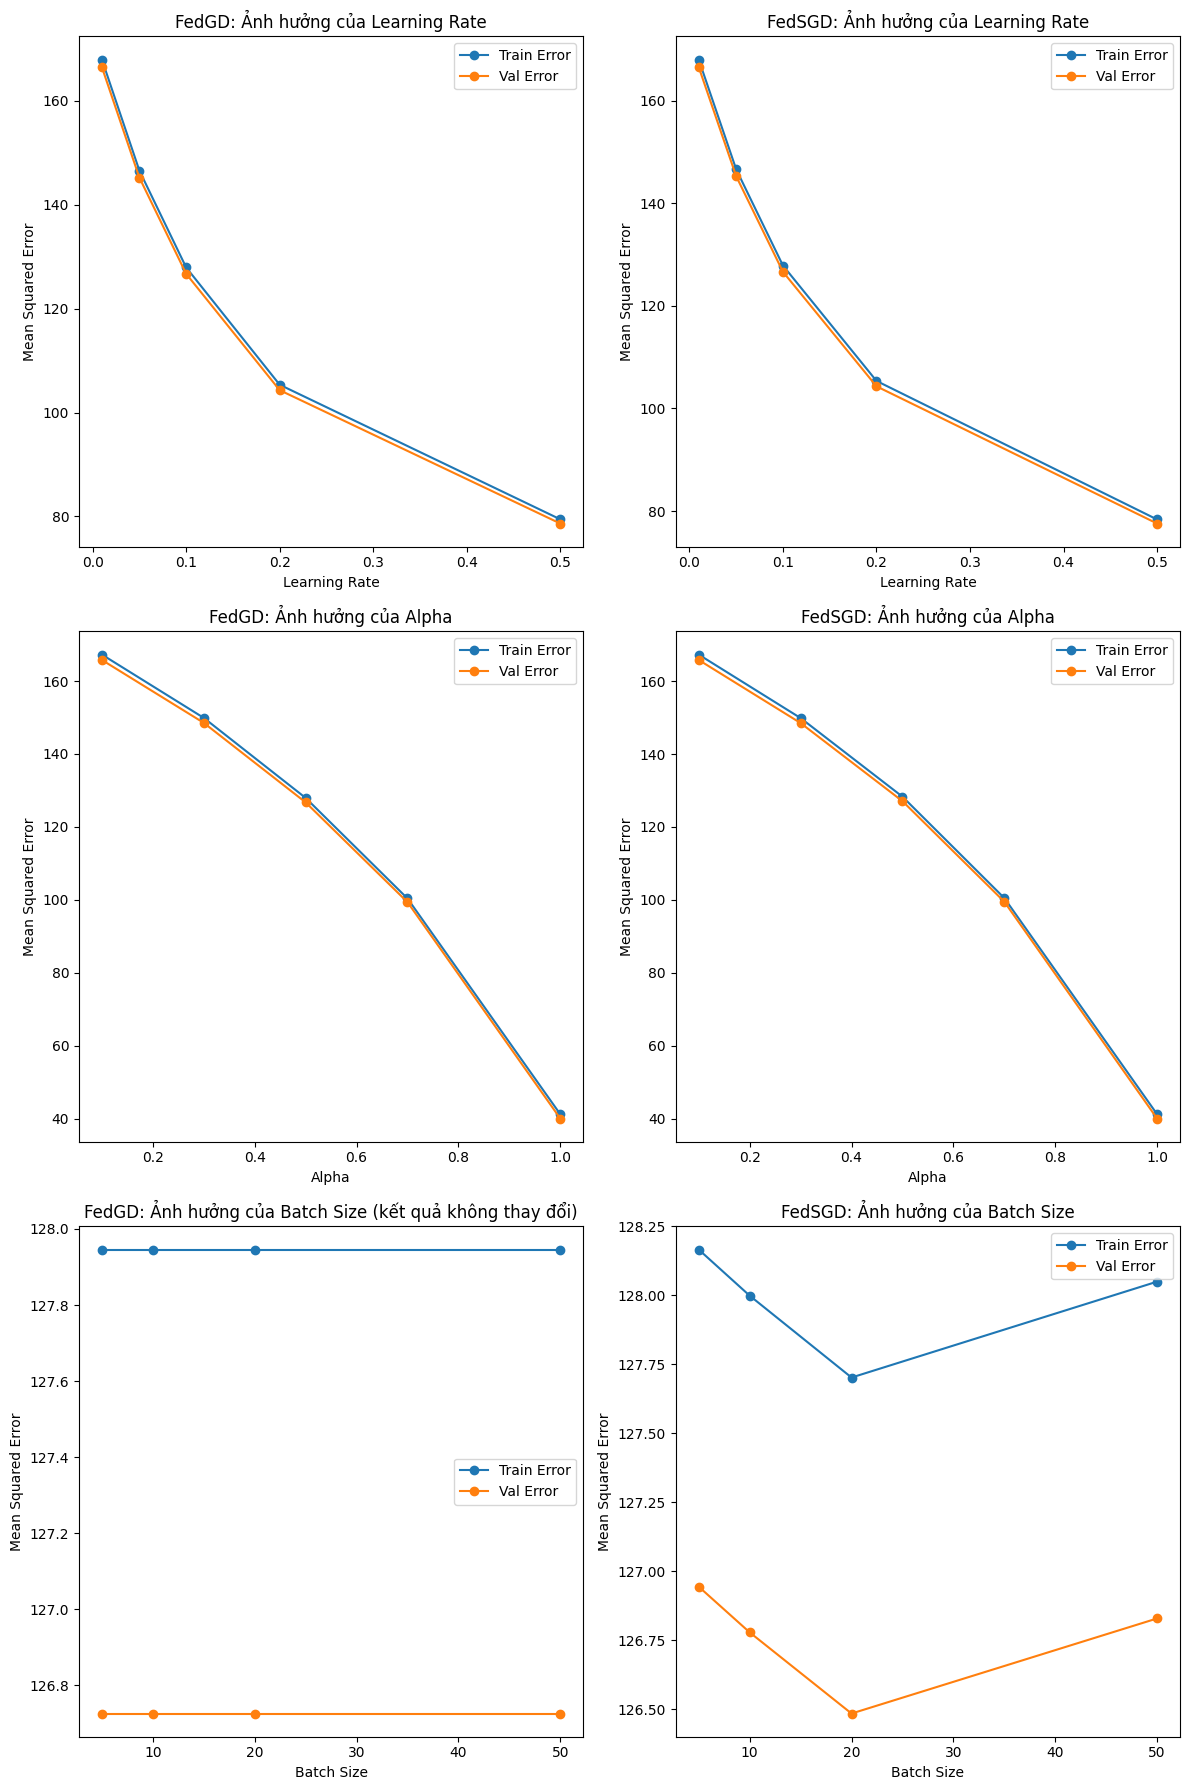

In [ ]:
# ===================== PHẦN 1: CHUẨN BỊ (Preparation) =====================

# 1.1 Import các thư viện cần thiết
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import networkx as nx
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

# ===================== PHẦN 2: ĐỌC DỮ LIỆU (Data) =====================

# Sử dụng thư viện files để upload file CSV từ máy tính của bạn (Google Colab)
from google.colab import files
print("Hãy tải lên file CSV của bạn (ví dụ: Assignment_MLBasicsData.csv)!")
uploaded = files.upload()

# Đọc dữ liệu từ file CSV đã tải lên (nếu tên file khác, hãy điều chỉnh lại)
data = pd.read_csv(list(uploaded.keys())[0])

# Xác định số lượng trạm (unique station names) và số lượng điểm dữ liệu
num_stations = len(data.name.unique())
num_datapoints = len(data)
print("Số lượng trạm:", num_stations)
print("Số lượng điểm dữ liệu:", num_datapoints)

# ===================== PHẦN 3: ĐỊNH NGHĨA HÀM TRỢ GIÚP (Helper Functions) =====================

# Hàm vẽ đồ thị các trạm FMI theo tọa độ
def plotFMI(G_FMI):
    # Trích xuất tọa độ của từng nút (trạm)
    coords = [G_FMI.nodes[i]['coord'] for i in range(len(G_FMI.nodes))]
    df_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),
                        df_coords["longitude"].to_numpy().reshape(-1,1)))
    fig, ax = plt.subplots()
    # Vẽ các nút
    for node in G_FMI.nodes:
        ax.scatter(coords[node, 1], coords[node, 0], color='black', s=4, zorder=5)
    # Thêm nhãn cho từng nút
    for node in G_FMI.nodes:
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node),
                fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Vẽ các cạnh nối giữa các nút
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1], coords[edge[1],1]],
                [coords[edge[0],0], coords[edge[1],0]],
                linestyle='-', color='gray')
    ax.set_xlabel('Kinh độ (longitude)')
    ax.set_ylabel('Vĩ độ (latitude)')
    ax.set_title('Các trạm FMI')
    plt.show()

# Hàm thêm các cạnh giữa các trạm theo số láng giềng gần nhất (numneighbors)
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(len(graph.nodes))]
    df_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),
                        df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for i in range(nrnodes):
        for j in range(nrnodes):
            if i != j and A[i, j] > 0:
                graph.add_edge(i, j)
    return graph

# Hàm trích xuất ma trận đặc trưng X và vector nhãn y từ dữ liệu của mỗi trạm.
# Giả sử dữ liệu có các cột: "Latitude", "Longitude", "temp", "Timestamp"
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    for ind in range(nrdatapoints):
        # Lấy vĩ độ và kinh độ (chuẩn hoá bằng cách chia cho 100)
        lat = float(data['Latitude'].iloc[ind]) / 100
        lon = float(data['Longitude'].iloc[ind]) / 100
        tmp = data['temp'].iloc[ind]
        # Lấy thời gian ghi nhận và chuyển thành đối tượng datetime
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Trích xuất năm, tháng, ngày, giờ, phút và chuẩn hoá về khoảng [0,1]
        year = float(date_object.year) / 2025
        month = float(date_object.month) / 13
        day = float(date_object.day) / 32
        hour = float(date_object.hour) / 25
        minute = float(date_object.minute) / 61
        X[ind, :] = [lat, lon, year, month, day, hour, minute]
        y[ind, :] = tmp
    return X, y

# ===================== PHẦN 4: XÂY DỰNG ĐỒ THỊ THỰC NGHIỆM (Empirical Graph) =====================

# Thiết lập các tham số chia tập dữ liệu
test_size = 0.2
seed = 1

# Tạo đối tượng đồ thị để lưu trữ các trạm FMI
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(num_stations))

# Với mỗi trạm, trích xuất dữ liệu cục bộ, tách thành tập huấn luyện và tập kiểm tra, và gán các thuộc tính vào nút
for i, station in enumerate(data.name.unique()):
    station_data = data[data.name == station]
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

    G_FMI.nodes[i]['samplesize'] = len(y)   # Số lượng mẫu của trạm
    G_FMI.nodes[i]['name'] = station         # Tên trạm
    # Lấy tọa độ (vĩ độ, kinh độ) dựa trên giá trị duy nhất
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0])
    G_FMI.nodes[i]['X_train'] = X_train       # Ma trận đặc trưng huấn luyện
    G_FMI.nodes[i]['y_train'] = y_train       # Vector nhãn huấn luyện
    G_FMI.nodes[i]['X_val'] = X_val           # Ma trận đặc trưng kiểm tra
    G_FMI.nodes[i]['y_val'] = y_val           # Vector nhãn kiểm tra
    # Khởi tạo tham số mô hình cho trạm (vector 0 có kích thước 7x1)
    G_FMI.nodes[i]['weights'] = np.zeros((7, 1))

# Thêm các cạnh giữa các trạm dựa trên số láng giềng gần nhất
numneighbors = 3
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)

# Hiển thị đồ thị các trạm FMI
plotFMI(G_FMI)

# ===================== PHẦN 5: MÔ HÌNH (MODEL) =====================

# Ta thực hiện huấn luyện mô hình với hai thuật toán:
# - FedGD: Federated Gradient Descent (sử dụng toàn bộ tập huấn luyện)
# - FedSGD: Federated Stochastic Gradient Descent (sử dụng mini-batch)

# ---------------- 5.1 FEDGD: Federated Gradient Descent ----------------

print("\n========== Chạy FedGD ==========")
max_iter = 1000   # Số vòng lặp huấn luyện
alpha = 0.5       # Tham số α dùng để chia sẻ trọng số giữa các trạm
l_rate = 0.1      # Tốc độ học

for iteration in range(max_iter):
    global_weights = np.zeros((7, 1))
    for i in range(num_stations):
        weights = G_FMI.nodes[i]['weights']
        X_train = G_FMI.nodes[i]['X_train']
        y_train = G_FMI.nodes[i]['y_train']
        # Tính gradient dựa trên lỗi bình phương trung bình (MSE)
        gradient = X_train.T @ (X_train @ weights - y_train) / len(y_train)
        weights = weights - l_rate * gradient
        G_FMI.nodes[i]['weights'] = weights
        # Tích lũy trọng số từ từng trạm (nhân với α)
        global_weights += alpha * weights
    global_weights = global_weights / num_stations
    # Đồng bộ trọng số cho tất cả các trạm về trọng số chung
    for i in range(num_stations):
        G_FMI.nodes[i]['weights'] = global_weights

# Tính lỗi huấn luyện và kiểm tra sau FedGD
train_errors = np.zeros(num_stations)
val_errors = np.zeros(num_stations)
for i in range(num_stations):
    X_train = G_FMI.nodes[i]['X_train']
    y_train = G_FMI.nodes[i]['y_train']
    X_val = G_FMI.nodes[i]['X_val']
    y_val = G_FMI.nodes[i]['y_val']
    weights = G_FMI.nodes[i]['weights']
    train_pred = X_train @ weights
    val_pred = X_val @ weights
    train_errors[i] = mean_squared_error(y_train, train_pred)
    val_errors[i] = mean_squared_error(y_val, val_pred)

print("Lỗi trung bình tập huấn luyện (FedGD):", np.mean(train_errors))
print("Lỗi trung bình tập kiểm tra (FedGD):", np.mean(val_errors))


# ---------------- 5.2 FEDSGD: Federated Stochastic Gradient Descent ----------------

print("\n========== Chạy FedSGD ==========")
batch_size = 10   # Kích thước batch dùng cho SGD

# Reset trọng số cho các trạm về vector 0
for i in range(num_stations):
    G_FMI.nodes[i]['weights'] = np.zeros((7, 1))

for iteration in range(max_iter):
    global_weights = np.zeros((7, 1))
    for i in range(num_stations):
        weights = G_FMI.nodes[i]['weights']
        X_train = G_FMI.nodes[i]['X_train']
        y_train = G_FMI.nodes[i]['y_train']
        # Chọn ngẫu nhiên một batch
        if len(X_train) < batch_size:
            idx = np.arange(len(X_train))
        else:
            idx = np.random.randint(0, len(X_train), size=batch_size)
        X_batch = X_train[idx]
        y_batch = y_train[idx]
        gradient = X_batch.T @ (X_batch @ weights - y_batch) / len(idx)
        weights = weights - l_rate * gradient
        G_FMI.nodes[i]['weights'] = weights
        global_weights += alpha * weights
    global_weights = global_weights / num_stations
    for i in range(num_stations):
        G_FMI.nodes[i]['weights'] = global_weights

# Tính lỗi huấn luyện và kiểm tra sau FedSGD
train_errors = np.zeros(num_stations)
val_errors = np.zeros(num_stations)
for i in range(num_stations):
    X_train = G_FMI.nodes[i]['X_train']
    y_train = G_FMI.nodes[i]['y_train']
    X_val = G_FMI.nodes[i]['X_val']
    y_val = G_FMI.nodes[i]['y_val']
    weights = G_FMI.nodes[i]['weights']
    train_pred = X_train @ weights
    val_pred = X_val @ weights
    train_errors[i] = mean_squared_error(y_train, train_pred)
    val_errors[i] = mean_squared_error(y_val, val_pred)

print("Lỗi trung bình tập huấn luyện (FedSGD):", np.mean(train_errors))
print("Lỗi trung bình tập kiểm tra (FedSGD):", np.mean(val_errors))


# ===================== PHẦN 6: PHÂN TÍCH ẢNH HƯỞNG SIÊU THAM SỐ =====================
# Phần này sẽ chạy các thí nghiệm với các giá trị siêu tham số khác nhau và vẽ biểu đồ so sánh
# ta sẽ xây dựng hai hàm cho thử nghiệm: một cho FedGD và một cho FedSGD.
#
# Lưu ý: Ta sử dụng deepcopy để sao chép cấu trúc đồ thị ban đầu (G_FMI)
# nhằm đảm bảo mỗi thí nghiệm đều khởi tạo lại tham số mô hình.

import copy

# Hàm chạy thí nghiệm với FedGD cho một cặp siêu tham số (alpha, l_rate)
def run_experiment_FedGD(alpha_val, l_rate_val, max_iter_exp=500):
    G_exp = copy.deepcopy(G_FMI)
    # Reset lại trọng số
    for i in range(num_stations):
        G_exp.nodes[i]['weights'] = np.zeros((7, 1))
    for iteration in range(max_iter_exp):
        global_weights = np.zeros((7, 1))
        for i in range(num_stations):
            weights = G_exp.nodes[i]['weights']
            X_train = G_exp.nodes[i]['X_train']
            y_train = G_exp.nodes[i]['y_train']
            gradient = X_train.T @ (X_train @ weights - y_train) / len(y_train)
            weights = weights - l_rate_val * gradient
            G_exp.nodes[i]['weights'] = weights
            global_weights += alpha_val * weights
        global_weights = global_weights / num_stations
        for i in range(num_stations):
            G_exp.nodes[i]['weights'] = global_weights
    # Tính lỗi trung bình
    train_err = []
    val_err = []
    for i in range(num_stations):
        X_train = G_exp.nodes[i]['X_train']
        y_train = G_exp.nodes[i]['y_train']
        X_val = G_exp.nodes[i]['X_val']
        y_val = G_exp.nodes[i]['y_val']
        weights = G_exp.nodes[i]['weights']
        train_err.append(mean_squared_error(y_train, X_train @ weights))
        val_err.append(mean_squared_error(y_val, X_val @ weights))
    return np.mean(train_err), np.mean(val_err)

# Hàm chạy thí nghiệm với FedSGD cho một cặp siêu tham số (alpha, l_rate, batch_size)
def run_experiment_FedSGD(alpha_val, l_rate_val, batch_size_val, max_iter_exp=500):
    G_exp = copy.deepcopy(G_FMI)
    for i in range(num_stations):
        G_exp.nodes[i]['weights'] = np.zeros((7,1))
    for iteration in range(max_iter_exp):
        global_weights = np.zeros((7, 1))
        for i in range(num_stations):
            weights = G_exp.nodes[i]['weights']
            X_train = G_exp.nodes[i]['X_train']
            y_train = G_exp.nodes[i]['y_train']
            if len(X_train) < batch_size_val:
                idx = np.arange(len(X_train))
            else:
                idx = np.random.randint(0, len(X_train), size=batch_size_val)
            X_batch = X_train[idx]
            y_batch = y_train[idx]
            gradient = X_batch.T @ (X_batch @ weights - y_batch) / len(idx)
            weights = weights - l_rate_val * gradient
            G_exp.nodes[i]['weights'] = weights
            global_weights += alpha_val * weights
        global_weights = global_weights / num_stations
        for i in range(num_stations):
            G_exp.nodes[i]['weights'] = global_weights
    train_err = []
    val_err = []
    for i in range(num_stations):
        X_train = G_exp.nodes[i]['X_train']
        y_train = G_exp.nodes[i]['y_train']
        X_val = G_exp.nodes[i]['X_val']
        y_val = G_exp.nodes[i]['y_val']
        weights = G_exp.nodes[i]['weights']
        train_err.append(mean_squared_error(y_train, X_train @ weights))
        val_err.append(mean_squared_error(y_val, X_val @ weights))
    return np.mean(train_err), np.mean(val_err)

#THÍ NGHIỆM 1: ẢNH HƯỞNG CỦA LEARNING RATE ----------------
# Danh sách tốc độ học cần thử nghiệm
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]

# Khởi tạo các danh sách lưu lỗi cho FedGD và FedSGD
fedgd_train_errors_lr = []
fedgd_val_errors_lr   = []
fedsgd_train_errors_lr = []
fedsgd_val_errors_lr   = []

for lr in learning_rates:
    train_err, val_err = run_experiment_FedGD(alpha_val=0.5, l_rate_val=lr, max_iter_exp=500)
    fedgd_train_errors_lr.append(train_err)
    fedgd_val_errors_lr.append(val_err)
    train_err_sgd, val_err_sgd = run_experiment_FedSGD(alpha_val=0.5, l_rate_val=lr, batch_size_val=10, max_iter_exp=500)
    fedsgd_train_errors_lr.append(train_err_sgd)
    fedsgd_val_errors_lr.append(val_err_sgd)

# ---------------- THÍ NGHIỆM 2: ẢNH HƯỞNG CỦA ALPHA ----------------
alphas = [0.1, 0.3, 0.5, 0.7, 1.0]

fedgd_train_errors_alpha = []
fedgd_val_errors_alpha   = []
fedsgd_train_errors_alpha = []
fedsgd_val_errors_alpha   = []

for a in alphas:
    train_err, val_err = run_experiment_FedGD(alpha_val=a, l_rate_val=0.1, max_iter_exp=500)
    fedgd_train_errors_alpha.append(train_err)
    fedgd_val_errors_alpha.append(val_err)
    train_err_sgd, val_err_sgd = run_experiment_FedSGD(alpha_val=a, l_rate_val=0.1, batch_size_val=10, max_iter_exp=500)
    fedsgd_train_errors_alpha.append(train_err_sgd)
    fedsgd_val_errors_alpha.append(val_err_sgd)

# ---------------- THÍ NGHIỆM 3: ẢNH HƯỞNG CỦA BATCH SIZE ----------------
batch_sizes = [5, 10, 20, 50]

# Vì FedGD huấn luyện toàn bộ dữ liệu nên không thay đổi kết quả khi batch_size thay đổi.
# Ta chạy FedGD 1 lần rồi sao chép kết quả cho tất cả giá trị batch size.
fedgd_train_const, fedgd_val_const = run_experiment_FedGD(alpha_val=0.5, l_rate_val=0.1, max_iter_exp=500)
fedgd_train_errors_bs = [fedgd_train_const for _ in batch_sizes]
fedgd_val_errors_bs   = [fedgd_val_const for _ in batch_sizes]

fedsgd_train_errors_bs = []
fedsgd_val_errors_bs   = []

for bs in batch_sizes:
    train_err_sgd, val_err_sgd = run_experiment_FedSGD(alpha_val=0.5, l_rate_val=0.1, batch_size_val=bs, max_iter_exp=500)
    fedsgd_train_errors_bs.append(train_err_sgd)
    fedsgd_val_errors_bs.append(val_err_sgd)

# ---------------- VẼ 6 ĐỒ THỊ: 3 hàng, mỗi hàng 2 biểu đồ (trái: FedGD, phải: FedSGD) ----------------
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# --- Hàng 1: Variation Learning Rate ---
axs[0, 0].plot(learning_rates, fedgd_train_errors_lr, marker='o', label='Train Error')
axs[0, 0].plot(learning_rates, fedgd_val_errors_lr, marker='o', label='Val Error')
axs[0, 0].set_title('FedGD: Ảnh hưởng của Learning Rate')
axs[0, 0].set_xlabel('Learning Rate')
axs[0, 0].set_ylabel('Mean Squared Error')
axs[0, 0].legend()

axs[0, 1].plot(learning_rates, fedsgd_train_errors_lr, marker='o', label='Train Error')
axs[0, 1].plot(learning_rates, fedsgd_val_errors_lr, marker='o', label='Val Error')
axs[0, 1].set_title('FedSGD: Ảnh hưởng của Learning Rate')
axs[0, 1].set_xlabel('Learning Rate')
axs[0, 1].set_ylabel('Mean Squared Error')
axs[0, 1].legend()

# --- Hàng 2: Variation Alpha ---
axs[1, 0].plot(alphas, fedgd_train_errors_alpha, marker='o', label='Train Error')
axs[1, 0].plot(alphas, fedgd_val_errors_alpha, marker='o', label='Val Error')
axs[1, 0].set_title('FedGD: Ảnh hưởng của Alpha')
axs[1, 0].set_xlabel('Alpha')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].legend()

axs[1, 1].plot(alphas, fedsgd_train_errors_alpha, marker='o', label='Train Error')
axs[1, 1].plot(alphas, fedsgd_val_errors_alpha, marker='o', label='Val Error')
axs[1, 1].set_title('FedSGD: Ảnh hưởng của Alpha')
axs[1, 1].set_xlabel('Alpha')
axs[1, 1].set_ylabel('Mean Squared Error')
axs[1, 1].legend()

# --- Hàng 3: Variation Batch Size ---
axs[2, 0].plot(batch_sizes, fedgd_train_errors_bs, marker='o', label='Train Error')
axs[2, 0].plot(batch_sizes, fedgd_val_errors_bs, marker='o', label='Val Error')
axs[2, 0].set_title('FedGD: Ảnh hưởng của Batch Size (kết quả không thay đổi)')
axs[2, 0].set_xlabel('Batch Size')
axs[2, 0].set_ylabel('Mean Squared Error')
axs[2, 0].legend()

axs[2, 1].plot(batch_sizes, fedsgd_train_errors_bs, marker='o', label='Train Error')
axs[2, 1].plot(batch_sizes, fedsgd_val_errors_bs, marker='o', label='Val Error')
axs[2, 1].set_title('FedSGD: Ảnh hưởng của Batch Size')
axs[2, 1].set_xlabel('Batch Size')
axs[2, 1].set_ylabel('Mean Squared Error')
axs[2, 1].legend()

plt.tight_layout()
plt.show()


dự đoán thời gian pin của fog